# Transfer Learning - Caso de osos (Isabel Artero)


En el siguiente notebook se desarrolla una red neuronal convolucional (CNN) preentrenada para identificar imagénes de osos dividididas en tres clases: negros (black), grizzly y ositos de peluche o no de carne y hueso (teddys).

La estructura que se muestra es la siguiente:
- Lectura de imagenes del dataset osos
- Arquitectura del modelo: VGG16 preentrenada con imagenet
    - Generador de imagenes
    - Fine-Tunning
    - Resultados
- Test con imagenes aleatorias
- Pruebas con otras CNN:
    - VGG16 preentrenada con imagenet pero con algunos cambios de hiperparámetros
    - Mobilenet preenetrenada con imagenet


## Dataset osos

Como ya he dicho, el dataset de osos está separado en tres clases o categorias: black, grizzly y teddys, cada uno de ellas en su correspondiente carpeta.

En total tenemos 240 imagenes, 80 de cada clase, por lo que es un dataset balanceado. 

Además, destacar que he creado una estructura de carpetas diferente al .tar entregado, encontramos:
- *train* con 60 imagenes de cada clase (las dadas por el profesor)
- *validation* con 20 de cada clase 
- *test* con 8 imagenes aleatorias

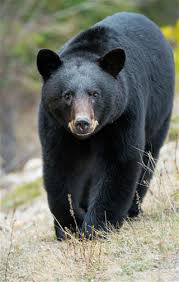

In [1]:
# Importamos librerias
import os
import tensorflow as tf

# Restablecemos notebook para que no se queden datos guardados en memoria
tf.keras.backend.clear_session()  

# Importamos imagenes
    # Libreria
from tensorflow.keras.preprocessing import image

    # Creo la ruta de mi path
base_path = 'C:/Users/isabe/OneDrive/Escritorio/M/14 Deep Learning/Tarea/osos/'

    # Cargo una imagen de cada categoria de mi carpeta train
image.load_img(base_path + 'train/black/00000017.jpg')

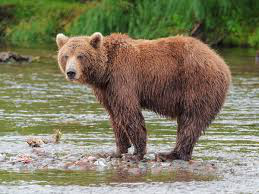

In [2]:
image.load_img(base_path + 'train/grizzly/00000039.jpg')

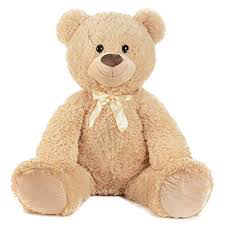

In [3]:
image.load_img(base_path + 'train/teddys/00000041.jpg')

## Arquitectura del modelo con vgg16 

Como vimos en clase, uso una red vgg16 pre-entreada en imagenet pero quitando la última capa porque nuestro dataset es muy pequeño. 
Además:
- Pooling con global average pooling para generar generalidad espacial
- Añadimos una capa densa de 512 y activación relu
- La última capa será otra conectada con 3 clases y activación softmax


In [4]:
# Importamos librerias
import pandas as pd
import numpy as np
import keras

from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import VGG16

# Importamos modelo vgg16 con imagenet y quitando la última capa
base_model=VGG16(weights='imagenet', include_top=False) 

# Añadidos:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x) 
preds = Dense(3, activation='softmax')(x) 

Using TensorFlow backend.


In [5]:
# Implementamos el modelo
from keras.models import Model

model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

#### Fine-tuning

Vemos que tenemos muchos parámetros a entrenar y pocas imágenes por lo que vamos a especificar que capas queremos entrenar para eliminar el número de parámetros entrenables.

Las capas inferiores abstraen características generales de las imagenes y las capas superiores características más específicas, por lo que congelamos esas primeras capas. Además, es una medida para evitar el sobreajuste.

In [6]:
# Vemos cuantas capas tiene el modelo base
len(base_model.layers)

19

In [7]:
# Y el modelo con nuestros añadidos
len(model.layers)

22

In [8]:
# Ahora especificamos cuantas capas queremos entrenar
# "Congelamos" las 19 primeras (guardamos el conocimiento pre-entrenado) y nos quedamos las 3 últimas

for layer in model.layers[:19]:
    layer.trainable=False
for layer in model.layers[19:]:
    layer.trainable=True

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Vemos que el número de parametros entrenables ha disminuido considerablemente, de casi 15 millones a 264.000

#### Generador de imagenes o Data Augmentation

Utilizamos el generador con la propia función de pre-procesado de la red vgg16 y añadimos el directorio de donde vienen las imagenes. 

El generador lo que hace es aumentar artificialmente el tamaño de mi dataset, creando imagenes muy similares a las que ya tengo, por ejemplo, cambiando la orientación. De esta manera, incrementa la capacidad del modelo de aprender y evitar el sobreajuste/"overfitting"

In [9]:
# Recuerdo mi path
base_path

# Path de train y validation
train_path      = os.path.join(base_path, 'train')
validation_path = os.path.join(base_path, 'validation')

In [10]:
# Importo librerias
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16

# Uso el generador propio de vgg16
datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16) 

# Generador de train y validation, le digo que las imagenes son de 224x224 en color

train_generator = datagen.flow_from_directory(train_path, 
                                                target_size=(224,224),
                                                # default parameters
                                                color_mode='rgb',
                                                batch_size=2,
                                                class_mode='categorical',
                                                shuffle=True)

validation_generator = datagen.flow_from_directory(validation_path, 
                                                    target_size=(224,224),
                                                    # default parameters
                                                    color_mode='rgb',
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


Compilamos el modelo utilizando el optimizador Adam, función de coste categorical Xentropy ya que es un problema de clasificación y entrenamos con 5 epochs. La métrica utilizada será el accuracy.
Además, añadimos el correcto step_size 


In [11]:
# Importamos librerias
from keras.optimizers import Adam

# Compilacion con Adam, loss categorical Xentropy y métrica accuracy
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['acc'])

# Entrenamos con el correcto step_size y 5 epochs
step_size_train=train_generator.n//train_generator.batch_size
hist = model.fit_generator(generator=train_generator,
                            steps_per_epoch=step_size_train,
                            epochs=5,
                            validation_data = validation_generator)

Epoch 1/5
120/120 [==============================] - 47s 393ms/step - loss: 1.7009 - acc: 0.8708 - val_loss: 0.0000e+00 - val_acc: 0.9667
Epoch 2/5
120/120 [==============================] - 51s 429ms/step - loss: 0.0916 - acc: 0.9750 - val_loss: 2.3603e-05 - val_acc: 0.9667
Epoch 3/5
120/120 [==============================] - 51s 426ms/step - loss: 0.2287 - acc: 0.9708 - val_loss: 5.9605e-08 - val_acc: 0.9167
Epoch 4/5
120/120 [==============================] - 51s 428ms/step - loss: 0.6016 - acc: 0.9458 - val_loss: 0.0000e+00 - val_acc: 0.9167
Epoch 5/5
120/120 [==============================] - 52s 433ms/step - loss: 0.2095 - acc: 0.9792 - val_loss: 0.0000e+00 - val_acc: 1.0000


#### Resultados

Finalmente, el accuracy es muy bueno.
Vemos gráficamente los resultados comparados entre train y validation.

En la primera gráfica vemos el comportamiento del accuracy a lo largo de los epochs, los valores de train y validation se separarn a partir del epoch 1 es probable que exista overfitting.

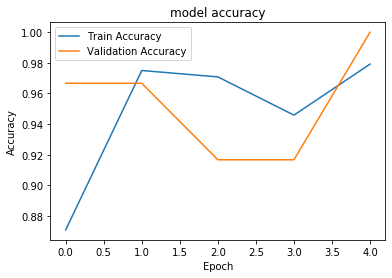

In [14]:
import matplotlib.pyplot as plt

# Gráfica Accuracy
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_acc'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy"])
plt.show()

En esta segunda gráfica que representa la función de coste vemos que los datos distan mucho entre train y validation para converger en el último epoch. Más adelante probaré esta misma red con algunos ajustes ya que veo varias señales de overfitting.

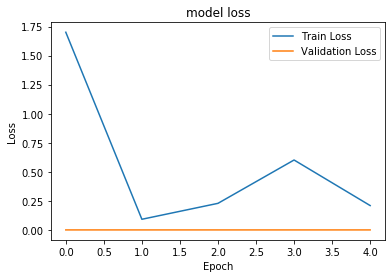

In [16]:
# Gráfica Loss
plt.plot(hist.history["loss"])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()

## Testeo de imagénes

He descargado algunas imagenes aleatorias de Google en una nueva carpeta llamada test. Testeo alguna aleatoriamente y toda la carpeta de vez.

Los resultados con las imagenes que yo tengo deberían de ser: 
    - 1 al 4 = grizzly
    - 5 = black
    - 6 al 8 = teddys
    

Para este testeo primero creamos una función de predicción (predict_image), en ella incluimos:
    - cargar las imagenes
    - ajustar tamaño de las imagenes para no tener problemas de memoria (224)
    - condiseración del batch de imagenes
    - preprocesado de la red
    - predicciones
    - predicción
    - diccionario de clases
    
Luego añadimos el path donde estarán las imagenes a predecir y testeo algunas imagenes. Observo que no está prediciendo bien la tercera imagen, posiblemente debido al overfitting ya que mi modelo no está aprendiendo sino que está memorizando las imagenes del dataset que le he dado para entrenar.

grizzly


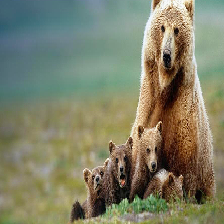

In [17]:
from numpy import expand_dims

class_dict = {v:k for k, v in train_generator.class_indices.items()}

# Función para predicir
def predict_image(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_vgg16(data)
    preds = model.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img

# Path donde estarán las imagenes
pred_path = 'C:/Users/isabe/OneDrive/Escritorio/M/14 Deep Learning/Tarea/osos/test'

# Imagen a predecir 1
predict_image(pred_path + '/1.jpg')

grizzly


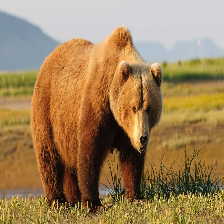

In [18]:
# Imagen a predecir 2
predict_image(pred_path + '/2.jpg')

black


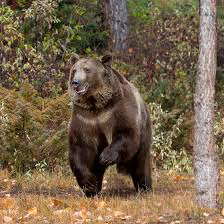

In [19]:
# Imagen a predecir 3
predict_image(pred_path + '/3.jpg')

grizzly


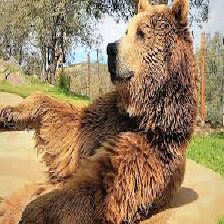

In [20]:
# Imagen a predecir 4
predict_image(pred_path + '/4.jpg')

black


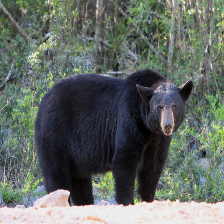

In [21]:
# Imagen a predecir 5
predict_image(pred_path + '/5.jpg')

teddys


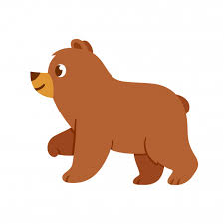

In [22]:
# Imagen a predecir 6
predict_image(pred_path + '/6.jpg')

In [23]:
# Le damos a predecir toda la carpeta y vemos que tampoco predice bien la tercera imagen
path  = base_path + 'test'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            predict_image(new_path)

grizzly
grizzly
black
grizzly
black
teddys
teddys
teddys


# Pruebas con otras redes neuronales

Pruebo con otras redes para observar la diferencias. 

## VGG6 con cambios de hiperparámetros

Realizo el mismo ejercicio que antes, VGG16 preentrenada con imagenet quitando la última capa, y con los siguientes cambios:
    - Utilizo función de activación 'sigmoid'
    - Puesto que esta función es más densa y necesita de más tiempo de computo y de número de epochs, aumento estos a 10
    - Añado un dropout de 0.5 para evitar el overfitting

In [24]:
from keras.layers import Dropout

# Importamos modelo vgg16 con imagenet y quitando la última capa
base_model2 = VGG16(weights='imagenet', include_top=False) 

# Añadidos:
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='sigmoid')(x)
x = Dropout(0.5)(x)
preds = Dense(3, activation='softmax')(x) 

# Implementamos el modelo
model2 = Model(inputs=base_model2.input, outputs=preds)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

Dado el gran número de parámetros, también quito las primeras capas (en este caso tengo una capa más que antes por el dropout)

In [25]:
for layer in model2.layers[:20]:
    layer.trainable=False
for layer in model2.layers[20:]:
    layer.trainable=True

model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

El generador lo dejamos igual, por lo que no lo repito.

A continuación compilo el modelo también con los mismos hiperparámetros que antes pero cambio el número de epochs a 10

In [26]:
# Compilacion con Adam, loss categorical Xentropy y métrica accuracy
model2.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['acc'])

# Entrenamos con el correcto step_size y 10 epochs
step_size_train=train_generator.n//train_generator.batch_size
hist2 = model2.fit_generator(generator=train_generator,
                            steps_per_epoch=step_size_train,
                            epochs=10,
                            validation_data = validation_generator)

Epoch 1/10
120/120 [==============================] - 46s 386ms/step - loss: 0.3730 - acc: 0.8417 - val_loss: 0.0776 - val_acc: 0.9833
Epoch 2/10
120/120 [==============================] - 52s 433ms/step - loss: 0.1135 - acc: 0.9625 - val_loss: 0.1071 - val_acc: 0.9833
Epoch 3/10
120/120 [==============================] - 53s 443ms/step - loss: 0.0783 - acc: 0.9667 - val_loss: 0.0023 - val_acc: 0.9667
Epoch 4/10
120/120 [==============================] - 54s 452ms/step - loss: 0.0664 - acc: 0.9750 - val_loss: 0.0355 - val_acc: 0.9833
Epoch 5/10
120/120 [==============================] - 57s 478ms/step - loss: 0.0743 - acc: 0.9708 - val_loss: 0.1116 - val_acc: 0.9833
Epoch 6/10
120/120 [==============================] - 51s 429ms/step - loss: 0.0570 - acc: 0.9833 - val_loss: 0.0016 - val_acc: 0.9667
Epoch 7/10
120/120 [==============================] - 54s 447ms/step - loss: 0.0459 - acc: 0.9792 - val_loss: 0.0040 - val_acc: 0.9833
Epoch 8/10
120/120 [==============================] - 5

Ahora veo que incluso siendo un accuracy mejor, no hay señales de overfitting, pues tanto el accuracy de train como de validation van a la par a partir del primer epoch.

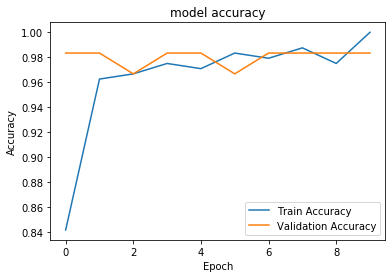

In [27]:
# Gráfica Accuracy
plt.plot(hist2.history["acc"])
plt.plot(hist2.history['val_acc'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy"])
plt.show()

Las funciones de loss también van a la par con excepción del octavo epoch que hace un pico. Para evitar esto, podríamos hacer una tercera variante de este modelo con 6 o 7 epochs, disminuyendo así más el overfitting.

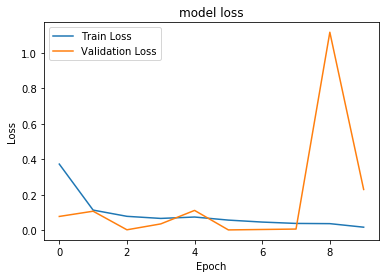

In [29]:
# Gráfica Loss
plt.plot(hist2.history["loss"])
plt.plot(hist2.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()

Vuelvo a definir la función de predicción ya que le he cambiado el nombre al modelo y veo que ahora los resultados son correctos:

In [30]:
# Función
def predict_image(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_vgg16(data)
    preds = model2.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img

# Testeo de mi carpeta
path  = base_path + 'test'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            predict_image(new_path)

grizzly
grizzly
grizzly
grizzly
black
teddys
teddys
teddys


## MobileNet

Finalmente, pruebo una red MobileNet también preentreada con imagenet y quitando la última capa, con 3 densas para que el modelo entienda resultados más complejos y obtener mejores resultados de clasificación. La última capa tendrá activación softmax y el pooling utilizado también será el Global Average.

In [32]:
from keras.applications import MobileNet

# Definición de la red
base_model3 = MobileNet(weights='imagenet', include_top=False) 

# Añadidos:
x = base_model3.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) 
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x) 
preds = Dense(3, activation='softmax')(x) 

C:\Users\isabe\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [33]:
# Vemos el modelo
model3 = Model(inputs=base_model3.input, outputs=preds)
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

Tambien tenemos muchos parámetros a entrenar por lo que "congelaré" las primeras capas

In [34]:
# Capas del modelo base
len(base_model3.layers)

87

In [35]:
# Capas del mi modelo
len(model3.layers)

92

In [37]:
# Congelar primeras capas y bajamos a más de la mitad de paramétros
for layer in model3.layers[:87]:
    layer.trainable=False
for layer in model3.layers[87:]:
    layer.trainable=True
    
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

En este caso tenemos que volver a construir el generador ya que utilizaré el de esta red:

In [38]:
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet

datagen3 = ImageDataGenerator(preprocessing_function=preprocess_mobilenet) 

train_generator = datagen3.flow_from_directory(train_path, 
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = datagen3.flow_from_directory(validation_path, 
                                                     target_size=(224,224),
                                                     color_mode='rgb',
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     shuffle=True)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


Compilo el modelo de igual manera que el vgg16 y lo entreno también con 5 epochs. Vemos resultados de manera gráfica

In [39]:
# Compilacion con Adam, loss categorical Xentropy y métrica accuracy
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

# Entrenamos con el correcto step_size y 5 epochs
step_size_train=train_generator.n//train_generator.batch_size

hist3 = model3.fit_generator(generator=train_generator,
                           steps_per_epoch=step_size_train,
                           epochs=5,
                           validation_data = validation_generator)

Epoch 1/5
7/7 [==============================] - 16s 2s/step - loss: 1.1578 - acc: 0.6010 - val_loss: 0.3387 - val_acc: 0.9667
Epoch 2/5
7/7 [==============================] - 15s 2s/step - loss: 0.2239 - acc: 0.9038 - val_loss: 0.0340 - val_acc: 1.0000
Epoch 3/5
7/7 [==============================] - 16s 2s/step - loss: 0.0525 - acc: 0.9821 - val_loss: 0.0357 - val_acc: 1.0000
Epoch 4/5
7/7 [==============================] - 14s 2s/step - loss: 0.0726 - acc: 0.9688 - val_loss: 0.0302 - val_acc: 0.9667
Epoch 5/5
7/7 [==============================] - 16s 2s/step - loss: 0.0395 - acc: 0.9866 - val_loss: 0.0129 - val_acc: 0.9833


Este modelo ha sido mucho más rápido que los de la red vgg16 y también da muy buenos resultados.

Vemo que no hay signos de overfitting con las funciones de accuracy:

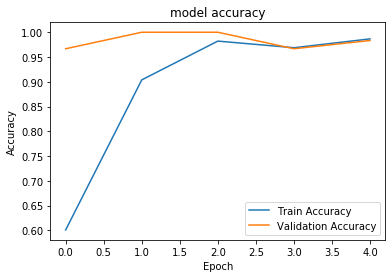

In [40]:
# Gráfica de Accuracy
plt.plot(hist3.history["acc"])
plt.plot(hist3.history['val_acc'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy"])
plt.show()

Y tampoco con las funciones de loss:

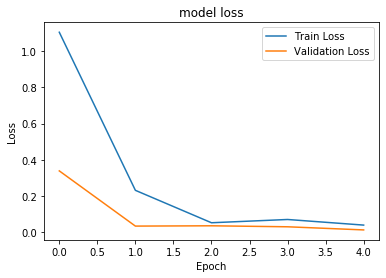

In [42]:
# Gráfica de Loss
plt.plot(hist3.history["loss"])
plt.plot(hist3.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train Loss","Validation Loss"])
plt.show()

Además de ser más rápida y no tener señales de overfitting, compruebo que clasifica bien mis imagenes de test. 

En este caso, igual que antes, vuelvo a definir la función ya que he cambiado de red y el nombre del modelo.

In [43]:
# Función para predecir
def predict_image(path):
    img = image.load_img(path)
    img = img.resize((224, 224))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_mobilenet(data)
    preds = model3.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img

# Testeo de mi carpeta
path  = base_path + 'test'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.jpg'): 
            new_path = os.sep.join([dirpath, filename])
            predict_image(new_path)

grizzly
grizzly
grizzly
grizzly
grizzly
black
teddys
teddys
teddys
